<a href="https://colab.research.google.com/github/prog815/traide/blob/main/%D0%9F%D0%BE%D0%B4%D0%B1%D0%BE%D1%80_%D0%B3%D0%B8%D0%BF%D0%B5%D1%80%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D0%BE%D0%B2_%D0%BF%D1%80%D0%BE%D1%81%D1%82%D0%BE%D0%B9_%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7_%D0%B7%D0%BD%D0%B0%D0%BA%D0%B0_%D0%BD%D0%B0_%D1%81%D0%B2%D0%B5%D1%80%D1%82%D0%BA%D0%B0%D1%85_(RandomSearch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключаем библиотеки

In [ ]:
! pip install yfinance
! pip install keras-tuner 

     |████████████████████████████████| 6.3 MB 7.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=489506387518ed3083cc37bd46351843df74d13b2561065a597a0fb2bd2aae0e
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 97 kB 3.8 MB/s 


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import keras_tuner as kt

# Загрузка котировок

## список тикеров

In [ ]:
acc_list = "TGKA	FEES	VTBR	TGKB	HYDR	TGKD	TGKN	RSTI	ENRU	SNGS	MRKV	GAZP	MRKZ	MRKP	SNGSP	MAGN	TGKDP	MSNG	MRKC	MRKU	NMTP	NLMK	MTLR	AFLT	MSRS	ROSN	TTLK	FESH	TRMK	RSTIP	RTKM	SIBN	AMEZ	ISKJ	DVEC	RASP	RTKMP	UTAR	LSNG	BSPB	MRKS	MVID	NKNCP	LSNGP	PIKK	KMAZ	IRKT	SVAV	CHEP	MRKK	KUBE	ROSB	KROT".split('\t')
acc_list = [f'{name}.ME' for name in acc_list]
np.array(acc_list)

array(['TGKA.ME', 'FEES.ME', 'VTBR.ME', 'TGKB.ME', 'HYDR.ME', 'TGKD.ME',
       'TGKN.ME', 'RSTI.ME', 'ENRU.ME', 'SNGS.ME', 'MRKV.ME', 'GAZP.ME',
       'MRKZ.ME', 'MRKP.ME', 'SNGSP.ME', 'MAGN.ME', 'TGKDP.ME', 'MSNG.ME',
       'MRKC.ME', 'MRKU.ME', 'NMTP.ME', 'NLMK.ME', 'MTLR.ME', 'AFLT.ME',
       'MSRS.ME', 'ROSN.ME', 'TTLK.ME', 'FESH.ME', 'TRMK.ME', 'RSTIP.ME',
       'RTKM.ME', 'SIBN.ME', 'AMEZ.ME', 'ISKJ.ME', 'DVEC.ME', 'RASP.ME',
       'RTKMP.ME', 'UTAR.ME', 'LSNG.ME', 'BSPB.ME', 'MRKS.ME', 'MVID.ME',
       'NKNCP.ME', 'LSNGP.ME', 'PIKK.ME', 'KMAZ.ME', 'IRKT.ME', 'SVAV.ME',
       'CHEP.ME', 'MRKK.ME', 'KUBE.ME', 'ROSB.ME', 'KROT.ME'], dtype='<U8')

## Загрузка из сети

In [ ]:
all_data = yf.download(acc_list,period='10y',threads=False)


[*********************100%***********************]  53 of 53 completed


In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2507 entries, 2011-09-05 to 2021-09-03
Columns: 318 entries, ('Adj Close', 'AFLT.ME') to ('Volume', 'VTBR.ME')
dtypes: float64(318)
memory usage: 6.1 MB


## Заполнить пустоты предыдущим

In [ ]:
all_data.fillna(method='pad',inplace=True)

# Подготовка данных

## К общему знаменателю (без сдвига)

### Входы (курсы + объем) (без сдвига)

In [ ]:
# inpData1 = np.hstack([(all_data[gr] / all_data['Close'].shift(1)).values for gr in ('Open','High','Low','Close')])
# inpData1.shape
d = [all_data[gr]/all_data['Close'].shift(1) for gr in ('Open','High','Low','Close')]
v = all_data['Volume'].apply(np.log1p)
v = v.diff()
d.append(v)
d = np.hstack([x.values for x in d])
d.shape

(2507, 265)

### Выход

In [ ]:
# outDataHigh = (all_data['High'] / all_data['Close'].shift(1)).values
# outDataLow = (all_data['Low'] / all_data['Close'].shift(1)).values
output = np.array((all_data['Close'].diff() > 0) * 1)
output.shape

(2507, 53)

## Первый вход - окно (без сдвига)

In [ ]:
WINDOW = 10
# d = pd.DataFrame(inpData1)
# inpData1 = np.hstack([d.shift(n).values for n in range(WINDOW)])
# inpData1.shape
inpData1 = np.ones((d.shape[0],WINDOW,d.shape[-1]))
d = pd.DataFrame(d)
for n in range(WINDOW):
    inpData1[:,n,:] = d.shift(n).values
inpData1.shape

(2507, 10, 265)

## Второй вход - даты (без сдвига)

In [ ]:
days = all_data.index.day.values
weekdays = all_data.index.weekday.values
months = all_data.index.month.values
x2sc = lambda x,per: np.transpose([np.sin(x/per*2*np.pi),np.cos(x/per*2*np.pi)])
inpData2 = np.hstack([x2sc(days,31),x2sc(weekdays,7),x2sc(months,12)])
inpData2.shape

(2507, 6)

## Разделяем обучение и расчет (появляется сдвиг)

In [ ]:
inpData1Calc = inpData1[-1,...]

inpData1Learn = inpData1
inpData1Learn[1:,...] = inpData1Learn[:-1,...]

inpData2Calc = inpData2[-1,...]

inpData2Learn = inpData2
inpData2Learn[1:,...] = inpData2Learn[:-1,...]

In [ ]:
inpData1Learn.shape,inpData2Learn.shape

((2507, 10, 265), (2507, 6))

In [ ]:
inpData1Calc.shape,inpData2Calc.shape

((10, 265), (6,))

In [ ]:
output.shape

(2507, 53)

## Чистим пустоты на обучении

In [ ]:
index = (~np.isnan(np.sum(inpData1Learn,axis=(1,2)))) & (~np.isnan(np.sum(inpData2Learn,axis=1))) & (~np.isnan(np.sum(output,axis=1)))
np.unique(index,return_counts=True)

(array([False,  True]), array([  11, 2496]))

In [ ]:
inpData1Learn = inpData1Learn[index,:]
inpData2Learn = inpData2Learn[index,:]
output = output[index,:]
learnDates = all_data.index.values[index]

In [ ]:
print('inpData1Learn size',inpData1Learn.shape)
print('inpData2Learn size',inpData2Learn.shape)
print('output size',output.shape)
print('Learn dates from',learnDates[0],'to',learnDates[-1])

inpData1Learn size (2496, 10, 265)
inpData2Learn size (2496, 6)
output size (2496, 53)
Learn dates from 2011-09-20T00:00:00.000000000 to 2021-09-03T00:00:00.000000000


## Разделение на обучение и тест

In [ ]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test, d_train, d_test = train_test_split(inpData1Learn,inpData2Learn,output,learnDates,test_size=0.33,shuffle=False)

## Нормировка данных (слой нормировки первого входа)

In [ ]:
normLayer = keras.layers.experimental.preprocessing.Normalization(axis=-1)
normLayer.adapt(X1_train)

# Модель

## Функция создания

In [ ]:
def build_model(hp):
    input1 = keras.layers.Input(shape=X1_train.shape[1:])
    x1 = normLayer(input1)

    units = hp.Choice('units',range(10,100))
    kernel = hp.Choice('kernel',range(2,5+1))
    x1 = keras.layers.Conv1D(units,
                             kernel,
                             padding='same',
                             activation='relu')(x1)

    x1 = keras.layers.Flatten()(x1)

    input2 = keras.layers.Input(shape=(X2_train.shape[1],))

    x = keras.layers.Concatenate()([x1,input2])

    output = keras.layers.Dense(1)(x)

    model = keras.Model((input1,input2),output)
    model.compile(optimizer=tf.optimizers.Adam(),
                loss=tf.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    # model.summary()
    return model

## Обучение

In [ ]:
pn = 'RandomSearch'
dir = '/tmp/tboard_logs/' + pn

cb = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',patience=100,restore_best_weights=True,verbose=False),
      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',patience=50,verbose=False)]

tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=100,
                        # overwrite=True,
                        project_name=pn)
tuner.search((X1_train,X2_train),y_train[:,0],
            epochs=1000,
            validation_split=0.3,
            verbose=False,
            callbacks = cb)

tuner.get_best_hyperparameters()[0].values

INFO:tensorflow:Oracle triggered exit


{'kernel': 2, 'units': 35}

ядро - 2 - маленькое
выход сверточной - 35 - ниже среднего

## Суммарно по лучшим

In [ ]:
tuner.results_summary()

Results summary
Results in ./RandomSearch
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 35
kernel: 2
Score: 0.5458167195320129
Trial summary
Hyperparameters:
units: 85
kernel: 2
Score: 0.5438246726989746
Trial summary
Hyperparameters:
units: 63
kernel: 2
Score: 0.541832685470581
Trial summary
Hyperparameters:
units: 19
kernel: 5
Score: 0.5398406386375427
Trial summary
Hyperparameters:
units: 34
kernel: 2
Score: 0.5398406386375427
Trial summary
Hyperparameters:
units: 25
kernel: 2
Score: 0.5338645577430725
Trial summary
Hyperparameters:
units: 11
kernel: 2
Score: 0.525896430015564
Trial summary
Hyperparameters:
units: 31
kernel: 2
Score: 0.525896430015564
Trial summary
Hyperparameters:
units: 69
kernel: 2
Score: 0.525896430015564
Trial summary
Hyperparameters:
units: 91
kernel: 2
Score: 0.5239043831825256


на валидации почти 55%

## Схема лучшей модели

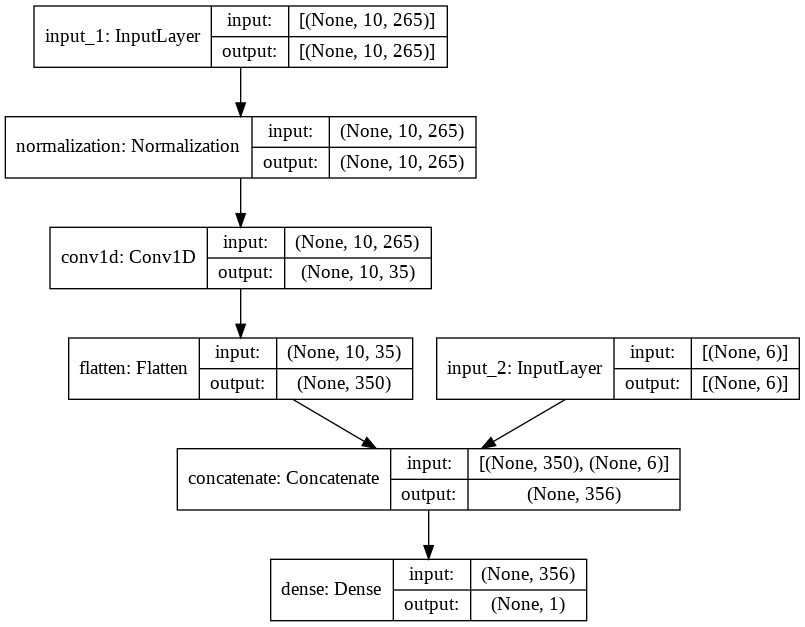

In [ ]:
best_model = tuner.get_best_models()[0]
keras.utils.plot_model(best_model,show_shapes=True)

## Отчет на тесте

In [ ]:
best_model.evaluate([X1_test,X2_test],y_test[:,0])

26/26 [==============================] - 0s 4ms/step - loss: 0.7275 - accuracy: 0.5485


[0.7275174260139465, 0.5485436916351318]

на тесте почти 55%
как на валидации
близкий результат

In [ ]:
test_res = best_model([X1_test,X2_test]).numpy()

print(classification_report(y_test[:,0],np.reshape((test_res > 0) * 1,-1)))



              precision    recall  f1-score   support

           0       0.56      0.50      0.53       441
           1       0.49      0.55      0.52       383

    accuracy                           0.52       824
   macro avg       0.52      0.52      0.52       824
weighted avg       0.53      0.52      0.52       824



52% нормы
все равно слабо

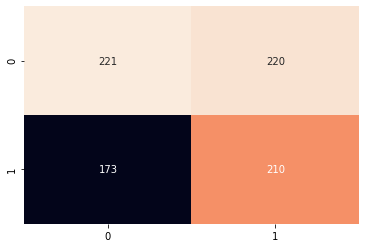

In [ ]:
sns.heatmap(confusion_matrix(y_test[:,0],np.reshape((test_res > 0) * 1,-1)),annot=True,fmt='.0f',cbar=False)

слабо на главно диагонали